## Dataset Creation

> **NOTE**: This notebook is a modification from the [original one](https://www.kaggle.com/code/amalhasni/creating-labeled-code-snippets-dataset) and it was executed on Kaggle.

In [1]:
from bq_helper import BigQueryHelper
import json

bq_assistant = BigQueryHelper("bigquery-public-data", "github_repos")

### Creating and Performing a Search Query


In [2]:
def get_condition(values):
    condition = [f'sample_path LIKE "%.{value}"' for value in values]
    return " OR ".join(condition)


def get_query(languages, limit=5000):
    query_template = """
        (SELECT sample_path, content
        FROM `bigquery-public-data.github_repos.sample_contents`
        WHERE (binary = False AND ({query}))
        LIMIT {limit})
        """
    query_list = [query_template.format(query=get_condition(lang), limit=limit) for lang in languages.values()]
    return "\nUNION ALL\n".join(query_list)

In [3]:
with open("../input/lang-table/languages.json", 'r') as f:
    lang_table = json.load(f)

QUERY = get_query(lang_table, limit=5000)
print(f'Estimated query size: {bq_assistant.estimate_query_size(QUERY)} GiB')

Estimated query size: 23.747745595872402 GiB


In [4]:
df = bq_assistant.query_to_pandas_safe(QUERY, max_gb_scanned=25)
print(f'Size of dataframe: {df.memory_usage(index=True, deep=True).sum() / (1024**3):.2f} GiB')

Size of dataframe: 1.04 GiB


### Exploring the Dataset and Visualizing results

In [5]:
from enum import Enum

class Language(Enum):
    TGLANG_LANGUAGE_OTHER = 0
    TGLANG_LANGUAGE_C = 1
    TGLANG_LANGUAGE_CPLUSPLUS = 2
    TGLANG_LANGUAGE_CSHARP = 3
    TGLANG_LANGUAGE_CSS = 4
    TGLANG_LANGUAGE_DART = 5
    TGLANG_LANGUAGE_DOCKER = 6
    TGLANG_LANGUAGE_FUNC = 7
    TGLANG_LANGUAGE_GO = 8
    TGLANG_LANGUAGE_HTML = 9
    TGLANG_LANGUAGE_JAVA = 10
    TGLANG_LANGUAGE_JAVASCRIPT = 11
    TGLANG_LANGUAGE_JSON = 12
    TGLANG_LANGUAGE_KOTLIN = 13
    TGLANG_LANGUAGE_LUA = 14
    TGLANG_LANGUAGE_NGINX = 15
    TGLANG_LANGUAGE_OBJECTIVE_C = 16
    TGLANG_LANGUAGE_PHP = 17
    TGLANG_LANGUAGE_POWERSHELL = 18
    TGLANG_LANGUAGE_PYTHON = 19
    TGLANG_LANGUAGE_RUBY = 20
    TGLANG_LANGUAGE_RUST = 21
    TGLANG_LANGUAGE_SHELL = 22
    TGLANG_LANGUAGE_SOLIDITY = 23
    TGLANG_LANGUAGE_SQL = 24
    TGLANG_LANGUAGE_SWIFT = 25
    TGLANG_LANGUAGE_TL = 26
    TGLANG_LANGUAGE_TYPESCRIPT = 27
    TGLANG_LANGUAGE_XML = 28
    
def update_language(name):
    try:
        return Language[name].value
    except KeyError:
        return None

In [6]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df["extension"] = df["sample_path"].apply(lambda x: x.split('.')[-1])
df["language"] = df["extension"].replace({ext: lang for lang, exts in lang_table.items() for ext in exts})
df["label"] = df["language"].map(update_language)
df.rename(columns={"content": "text"}, inplace=True)
df.dropna(inplace=True)
df["label"] = df["label"].astype(int)

df.head()

,sample_path,text,extension,language,label
0,docs/launch-k6nele-ex2.sh,#!/bin/sh\n\n# Example of launching Kõnele usi...,sh,TGLANG_LANGUAGE_SHELL,22
1,test/sh/bindings.python.DataTypeListInt.sh,"#!/bin/sh\n\npython ""${HYPERDEX_SRCDIR}""/test/...",sh,TGLANG_LANGUAGE_SHELL,22
2,plugin/thesaurus-lookup.sh,#!/usr/bin/env sh\n\n# Vim plugin for looking ...,sh,TGLANG_LANGUAGE_SHELL,22
3,lobcder-tests/scripts/testIt.sh,#!/bin/bash\n\n# $HOME/servers/apache-tomcat-6...,sh,TGLANG_LANGUAGE_SHELL,22
4,scripts/weight/cpw200plus.sh,#!/bin/bash\n#\n# Reads the weight from an Ada...,sh,TGLANG_LANGUAGE_SHELL,22


In [7]:
total_samples = len(df)
label_percentages = df["language"].value_counts(normalize=True) * 100

print("Total number of samples:", total_samples)
print("Samples distribution:")
for label, percentage in label_percentages.items():
    print(f'  - {label}: {percentage:.1f}%')

Total number of samples: 106836
Samples distribution:
  - TGLANG_LANGUAGE_JAVA: 4.7%
  - TGLANG_LANGUAGE_OBJECTIVE_C: 4.7%
  - TGLANG_LANGUAGE_CSS: 4.7%
  - TGLANG_LANGUAGE_SHELL: 4.7%
  - TGLANG_LANGUAGE_SWIFT: 4.7%
  - TGLANG_LANGUAGE_RUBY: 4.7%
  - TGLANG_LANGUAGE_LUA: 4.7%
  - TGLANG_LANGUAGE_PHP: 4.7%
  - TGLANG_LANGUAGE_C: 4.7%
  - TGLANG_LANGUAGE_PYTHON: 4.7%
  - TGLANG_LANGUAGE_CSHARP: 4.7%
  - TGLANG_LANGUAGE_CPLUSPLUS: 4.7%
  - TGLANG_LANGUAGE_GO: 4.7%
  - TGLANG_LANGUAGE_TYPESCRIPT: 4.7%
  - TGLANG_LANGUAGE_HTML: 4.7%
  - TGLANG_LANGUAGE_JSON: 4.7%
  - TGLANG_LANGUAGE_XML: 4.7%
  - TGLANG_LANGUAGE_JAVASCRIPT: 4.7%
  - TGLANG_LANGUAGE_SQL: 4.7%
  - TGLANG_LANGUAGE_NGINX: 4.3%
  - TGLANG_LANGUAGE_RUST: 3.0%
  - TGLANG_LANGUAGE_DART: 1.4%
  - TGLANG_LANGUAGE_POWERSHELL: 1.3%
  - TGLANG_LANGUAGE_KOTLIN: 1.1%
  - TGLANG_LANGUAGE_SOLIDITY: 0.1%
  - TGLANG_LANGUAGE_DOCKER: 0.0%


Text(0.5,1,'Number of code snippets per language')

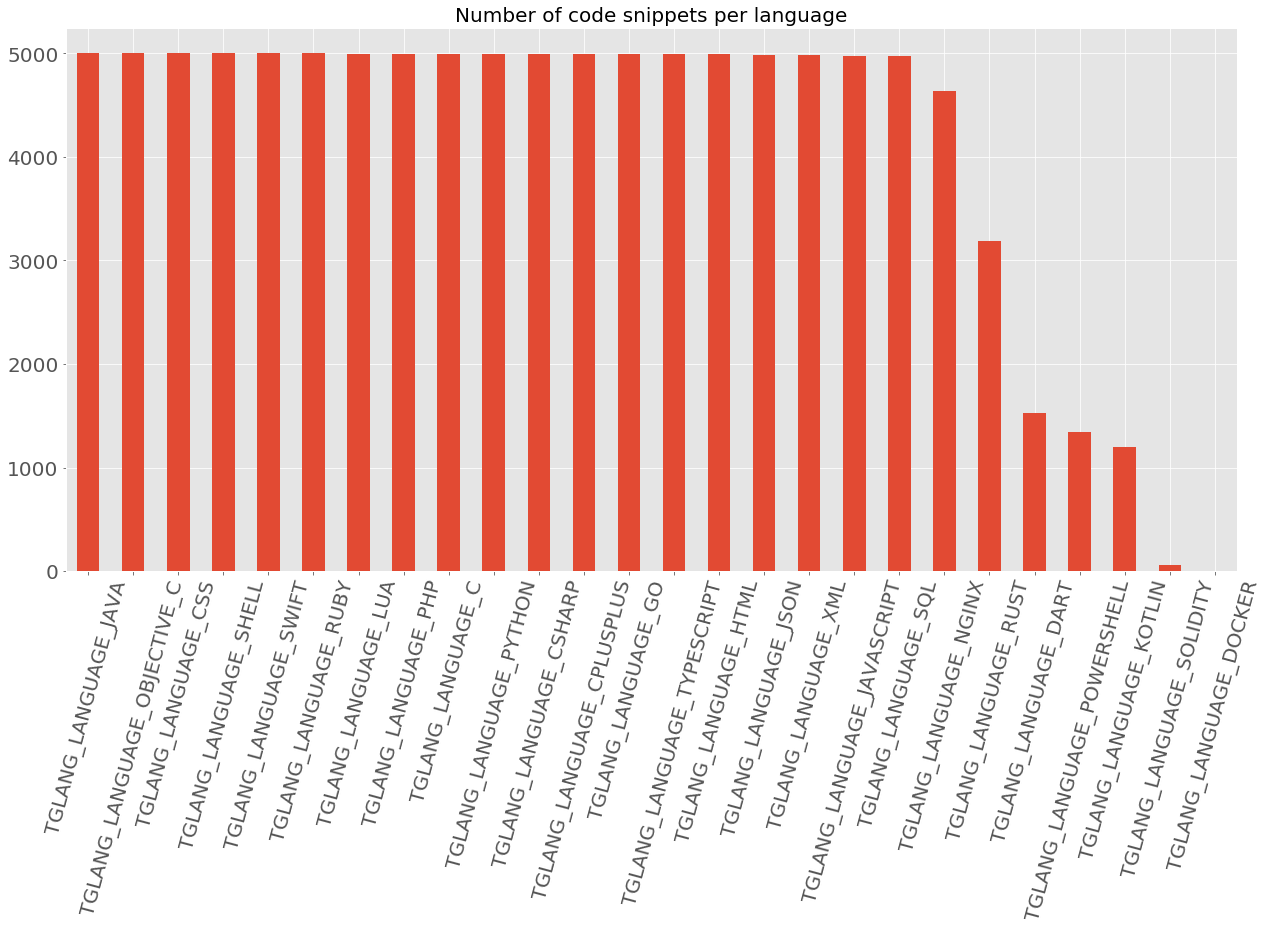

In [8]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

df["language"].value_counts().plot(kind='bar',figsize = (21,10), fontsize=20, rot=75)
plt.title("Number of code snippets per language", fontsize=20)

### Exporting the Dataset to a CSV file

In [9]:
from IPython.display import FileLink

df.to_csv("data.csv", index=False, columns=('text', 'label'))
FileLink(r'data.csv')

/kaggle/working/data.csv